In [1]:
!pip install git+https://github.com/PGelss/scikit_tt

  Cloning https://github.com/PGelss/scikit_tt to /tmp/pip-req-build-bke_1qt_
  Running command git clone -q https://github.com/PGelss/scikit_tt /tmp/pip-req-build-bke_1qt_
  Created wheel for scikit-tt: filename=scikit_tt-1.0-py3-none-any.whl size=57302 sha256=b281a1db934b1494bfaec9839196bb4b604506959c887f815b80322e4b2d148d
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsqxbh73/wheels/f8/48/47/eda0e04fa2fcc6ae219f9a69c9cf933ba6e0b79c8d46481fb7
Successfully built scikit-tt


In [2]:
!git clone https://github.com/tensorly/tensorly
%cd tensorly

Cloning into 'tensorly'...
remote: Enumerating objects: 8795, done.
remote: Counting objects: 100% (2405/2405), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 8795 (delta 2267), reused 2174 (delta 2136), pack-reused 6390
Receiving objects: 100% (8795/8795), 2.92 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (6407/6407), done.
/content/tensorly


In [3]:
!pip install -e .

Obtaining file:///content/tensorly
  Running setup.py develop for tensorly


## Library 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import io
import os
import random
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 16]
import random
import glob
# import subprocess
import os
from PIL import Image
import os
import xarray as xr
from matplotlib.pyplot import imshow, figure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time


In [5]:
import tensorly as tl
from tensorly import random
tl.set_backend('numpy')
import tensorly.backend as T
import tensorly.tenalg as tg
from tensorly.decomposition import tucker, parafac, non_negative_tucker

In [6]:
np.set_printoptions(precision=5)
np.array([1.123456789])
[1.1235]

[1.1235]

## Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
ds = xr.open_mfdataset('/content/drive/MyDrive/data/df_2004_2021.nc')

In [8]:
ds['TMAX'].data

dask.array<open_dataset-f8064e8a1a85bdcb71a942c18b2e0294TMAX, shape=(5844, 50, 94), dtype=float64, chunksize=(5844, 50, 94), chunktype=numpy.ndarray>

In [9]:
dX= ds['TMAX'].values
dX = np.swapaxes(dX, 0,-1)
dX = np.swapaxes(dX, 0,1)

## Tucker Decomp

In [10]:
core, factors = tucker(tl.tensor(dX), rank=[25, 25, 55], n_iter_max=350)

In [11]:
recon_dX = tl.tucker_to_tensor((core, factors))

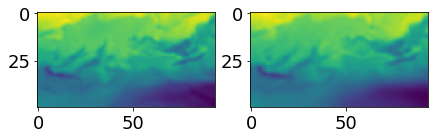

In [12]:
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.imshow(dX[:,:,100])
plt.subplot(1,2,2)
plt.imshow(recon_dX[:,:,100])

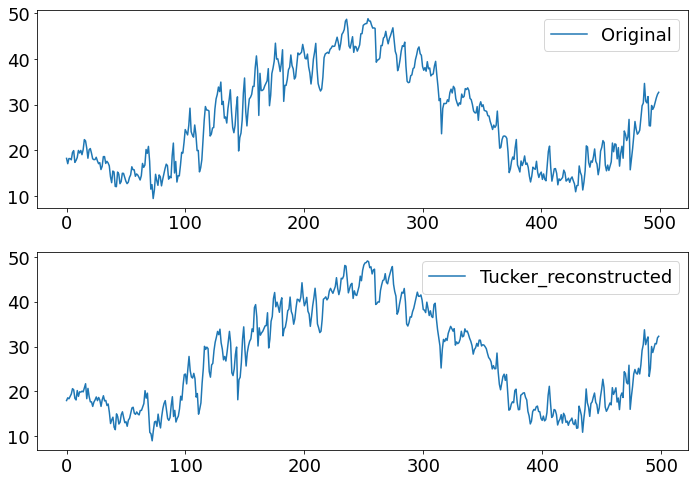

In [13]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(dX[1,1,:500], label='Original')
plt.legend()
plt.subplot(2,1,2)
plt.plot(recon_dX[1,1,1:500], label='Tucker_reconstructed')
plt.legend()
plt.tight_layout()

## MAR

In [14]:
def MAR(X, pred_step, maxiter = 100):
    m, n, T = X.shape
    B = np.random.randn(n, n)
    for it in range(maxiter):
        temp0 = B.T @ B
        temp1 = np.zeros((m, m))
        temp2 = np.zeros((m, m))
        for t in range(1, T):
            temp1 += X[:, :, t] @ B @ X[:, :, t - 1].T
            temp2 += X[:, :, t - 1] @ temp0 @ X[:, :, t - 1].T
        A = temp1 @ np.linalg.inv(temp2)
        temp0 = A.T @ A
        temp1 = np.zeros((n, n))
        temp2 = np.zeros((n, n))
        for t in range(1, T):
            temp1 += X[:, :, t].T @ A @ X[:, :, t - 1]
            temp2 += X[:, :, t - 1].T @ temp0 @ X[:, :, t - 1]
        B = temp1 @ np.linalg.inv(temp2)
    tensor = np.append(X, np.zeros((m, n, pred_step)), axis = 2)
    for s in range(pred_step):
        tensor[:, :, T + s] = A @ tensor[:, :, T + s - 1] @ B.T
    return tensor[:, :, - pred_step :]

## t_DMD Functions

In [15]:
import numpy as np
import scipy.linalg as lin
from scikit_tt.tensor_train import TT

In [16]:
def tdmd_exact(x, y, threshold=0, ortho_l=True, ortho_r=True):
    """
    Exact TDMD.
    Tensor-based version of exact DMD. See [1]_ for details.
    Parameters
    ----------
    x : TT
        tensor train containing the snapshots
    y : TT
        tensor-train containing the shifted snapshots
    threshold : float, optional
        threshold for SVDs, default is 0
    ortho_l : bool, optional
        whether to left-orthonormalize the first TT cores of x, default is True
    ortho_r : bool, optional
        whether to right-orthonormalize the last TT cores of x, default is True
    Returns
    -------
    dmd_eigenvalues : np.ndarray
        vector containing the DMD eigenvalues
    dmd_modes : TT
        tensor train containing the DMD modes
    References
    ----------
    .. [1] S. Klus, P. Gelß, S. Peitz, C. Schütte, "Tensor-based Dynamic Mode Decomposition", Nonlinearity 31 (7) (2018)
           3359
    """

    # compute pseudoinverse of x
    x = x.pinv(x.order - 1, threshold=threshold, ortho_l=ortho_l, ortho_r=ortho_r)

    # compute reduced matrix
    reduced_matrix = __tdmd_reduced_matrix(x, y)

    # compute eigenvalues and eigenvectors of the reduced matrix
    # noinspection PyTupleAssignmentBalance
    eigenvalues, eigenvectors = lin.eig(reduced_matrix, overwrite_a=True, check_finite=False)
    
    # sort eigenvalues
    ind = np.argsort(eigenvalues)[::-1]
    dmd_eigenvalues = eigenvalues[ind]

    # compute exact DMD modes
    dmd_modes = y.copy()
    dmd_modes.cores[-1] = y.cores[-1][:, :, 0, 0].dot(x.cores[-1][:, :, 0, 0].T).dot(eigenvectors[:, ind]).dot(np.diag(
        np.reciprocal(dmd_eigenvalues)))
    dmd_modes.row_dims[-1] = len(ind)

    return dmd_eigenvalues, dmd_modes


def tdmd_standard(x, y, threshold=0, ortho_l=True, ortho_r=True):
    """
    Standard TDMD.
    Tensor-based version of standard DMD. See [1]_ for details.
    Parameters
    ----------
    x : TT
        tensor train containing the snapshots
    y : TT
        tensor-train containing the shifted snapshots
    threshold : float, optional
        threshold for SVDs, default is 0
    ortho_l : bool, optional
        whether to left-orthonormalize the first TT cores of x, default is True
    ortho_r : bool, optional
        whether to right-orthonormalize the last TT cores of x, default is True
    Returns
    -------
    dmd_eigenvalues : np.ndarray
        vector containing the DMD eigenvalues
    dmd_modes : TT
        tensor train containing the DMD modes
    References
    ----------
    .. [1] S. Klus, P. Gelß, S. Peitz, C. Schütte, "Tensor-based Dynamic Mode Decomposition", Nonlinearity 31 (7) (2018)
           3359
    """

    # compute pseudoinverse of x
    x = x.pinv(x.order - 1, threshold=threshold, ortho_l=ortho_l, ortho_r=ortho_r)

    # compute reduced matrix
    reduced_matrix = __tdmd_reduced_matrix(x, y)

    # compute eigenvalues and eigenvectors of the reduced matrix
    # noinspection PyTupleAssignmentBalance
    eigenvalues, eigenvectors = lin.eig(reduced_matrix, overwrite_a=True, check_finite=False)

    # sort eigenvalues
    ind = np.argsort(eigenvalues)[::-1]
    dmd_eigenvalues = eigenvalues[ind]

    # compute standard DMD modes
    dmd_modes = x.copy()
    dmd_modes.cores[-1] = eigenvectors[:, ind, None, None]
    dmd_modes.row_dims[-1] = len(ind)

    return dmd_eigenvalues, dmd_modes


def __tdmd_reduced_matrix(x, y):
    """
    Compute the reduced matrix for finding DMD eigenvalues. See [1]_ for details.
    Parameters
    ----------
    x : TT
        tensor train containing the snapshots
    y : TT
        tensor-train containing the shifted snapshots
    Returns
    -------
    np.ndarray
        reduced matrix
    References
    ----------
    .. [1] S. Klus, P. Gelß, S. Peitz, C. Schütte, "Tensor-based Dynamic Mode Decomposition", Nonlinearity 31 (7) (2018)
           3359
    """

    # construct reduced matrix
    # ------------------------

    # contract first cores of x and y and reshape
    contraction = np.tensordot(x.cores[0], y.cores[0], axes=(1,1)).reshape([1, x.ranks[1]*y.ranks[1]])

    # set reduced_matrix to contraction
    reduced_matrix = contraction

    # loop over all cores except the last
    for i in range(1, x.order - 1):

        # contract ith cores of x and y and reshape
        contraction = np.tensordot(x.cores[i], y.cores[i], axes=(1,1)).transpose([0, 1, 3, 2, 4, 5]).reshape([x.ranks[i]*y.ranks[i], x.ranks[i+1]*y.ranks[i+1]])

        # multiply reduced_matrix with contraction
        reduced_matrix = reduced_matrix.dot(contraction)

    # reshape reduced_matrix to 2-dimensional array
    reduced_matrix = reduced_matrix.reshape([x.ranks[-2], y.ranks[-2]])

    # contract last cores and reshape
    contraction = np.tensordot(x.cores[-1], y.cores[-1], axes=(1, 1)).reshape([x.ranks[-2], y.ranks[-2]]).T

    # multiply reduced_matrix with contraction
    reduced_matrix = reduced_matrix.dot(contraction)

    return reduced_matrix

In [21]:
def give_propogator(x,y,number_of_snapshots=10, threshold=1e-9, modeltype='exact', dt=1):

  # x = TT(train[:, :, 0:number_of_snapshots, None, None, None])
  # y = TT(train[:, :, 1:number_of_snapshots + 1, None, None, None])

  eigenvalues_tdmd = [None] 
  modes_tdmd = [None] 

  if modeltype=='exact':
     eigenvalues_tdmd, modes_tdmd = tdmd_exact(x, y, threshold=threshold)
  elif modeltype=='standard':
     eigenvalues_tdmd, modes_tdmd = tdmd_standard(x, y, threshold=threshold)
  else:
      print('Error /or This Model Type In Not Implemented Yet :( ');


  modes_tdmd_full = modes_tdmd.full()[:, :, :, 0, 0, 0]

  Lambda = np.diag(eigenvalues_tdmd);
  tt_lambda=TT(Lambda[None, None, :,None,None,:])

  tt_Phi = TT(modes_tdmd_full[:,:, :, None, None, None])
  tt_Phit=tt_Phi.transpose(2)
  del modes_tdmd_full
  pinv_modes = tt_Phi.pinv(tt_Phi.order - 1, threshold=threshold, ortho_l=True, ortho_r=True);
  del tt_Phi
  pinv_modes=pinv_modes.transpose()
  pinv_modest = pinv_modes.transpose(2)
  del pinv_modes
  Omega = np.log(eigenvalues_tdmd)/dt
  # tt_Phi_l = tt_Phit.dot(tt_lambda).ortho()
  # Aprop = tt_Phi_l.dot(pinv_modest).ortho()
  Aprop=0;
  return  Aprop, tt_Phit, pinv_modest, tt_lambda, Omega  ## (Aprop) Popagator, TDMD Modes, inv(TDMD Modes), TT_Lambda, Omega

In [22]:
def give_pred(pinv_ttPhi ,Omega,train, steps):
   x0 =  TT(train[:, :, 0, None, None, None, None])
   t=0.01*np.arange(1,steps+1)
   b=pinv_ttPhi.dot(x0).ortho()
   tds=np.zeros((pinv_ttPhi.row_dims[-1],len(t)),dtype = 'complex_')
   for it in range(len(t)):
      tds[:,it] = (b.full()[0,0,:,0,0,0])*(np.exp(Omega*t[it]))
   ###########################
   tt_tds =TT(tds[None,None,:,None,None,:]) 
   
   predtt = tt_Phit.dot(tt_tds).ortho()
   predttf = np.real(predtt.full()[:,:,0,0,0,:])
   return tds, tt_tds, predtt, predttf 

## Examples

In [81]:
X=recon_dX[:,:,0:244].copy()
train = X[:,:,0:200]
test = X[:,:,200:]

# X=np.swapaxes(np.arange(0,900).reshape(-1,5,6), 0,2)
# train = X[:,:,0:22]
train = train/np.max(train)
# test = X[:,:,22:]
test = test/np.max(train)
X.shape, train.shape, test.shape

((50, 94, 244), (50, 94, 200), (50, 94, 44))

In [42]:
# plt.imshow(train[:,:,-1])

In [43]:
# plt.imshow(test[:,:,5])

In [82]:
# construct x and y tensors and convert to TT format
number_of_snapshots=train.shape[-1] - 1

x = TT(train[:, :, 0:number_of_snapshots, None, None, None])
y = TT(train[:, :, 1:number_of_snapshots + 1, None, None, None])

In [96]:
t1 = time.time()
Aprop, tt_Phit, pinv_ttPhi, tt_lambda, Omega =give_propogator(x=x,y=y, number_of_snapshots=number_of_snapshots, threshold=1e-50, modeltype='exact', dt=0.01)
print("--- %s seconds ---" % (time.time() - t1))

--- 3.0630176067352295 seconds ---


In [97]:
_, _, _,predttf =  give_pred(pinv_ttPhi, Omega, train, steps=20)

In [98]:
# predf = predttf[:,:,21:]
# predf.shape

In [99]:
# predttf[:,:,20]

In [100]:
# train[:,:,21]

In [101]:
# predf[:,:,3]

In [102]:
# 
# test[:,:,3]

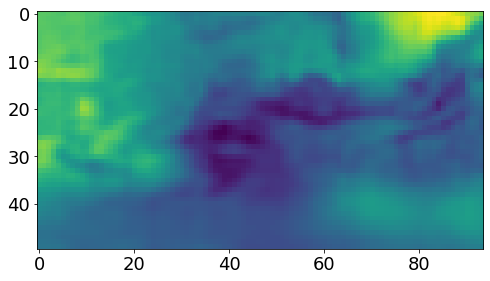

In [103]:
plt.imshow(predttf[:,:,4])

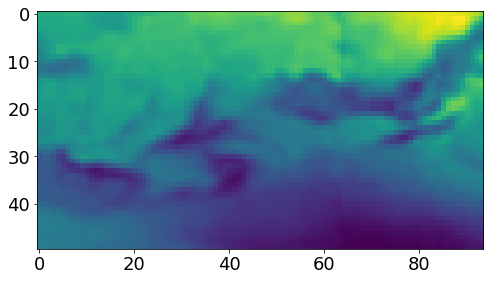

In [104]:
plt.imshow(X[:,:,1])

In [77]:
s1= train[:,:,1].reshape(-1,1)
s2 = predttf[:,:,4].reshape(-1,1)

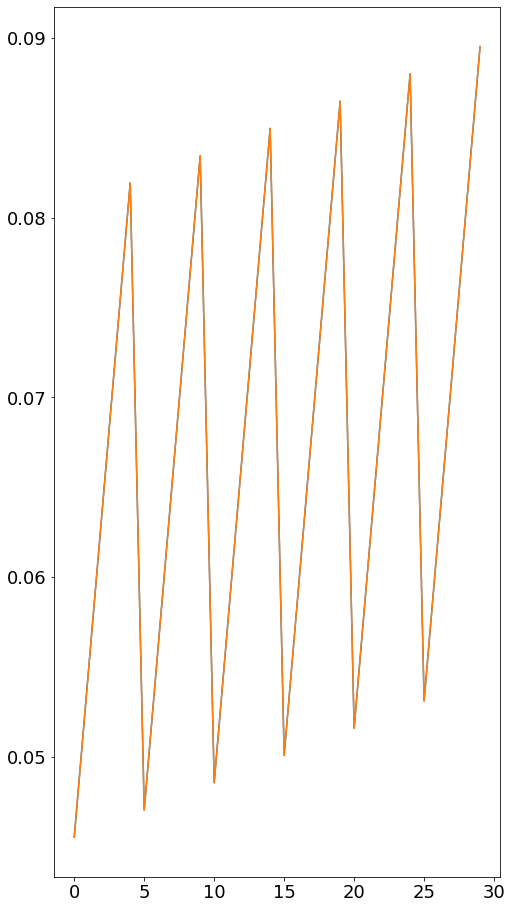

In [78]:
plt.plot(s1)
plt.plot(s2)

# prop_based

In [ ]:
# ApropF= (Aprop.full()).reshape(np.prod(Aprop.row_dims), np.prod(Aprop.col_dims))

In [ ]:
# steps = 10
# pr=train[:,:,0].reshape(-1,)
# forecast= np.zeros((len(pr),steps));
# forecast[:,0]=pr
# t2=  time.time()
# for step in range(steps-1):
#     forecast[:,step+1]=(np.real(ApropF@forecast[:,step])).reshape(-1,)
# print("--- %s seconds ---" % (time.time() - t2))   
# forecast=np.round(forecast.reshape(train.shape[0],train.shape[1],steps))    

In [ ]:
# forecast[:,:,1]

In [ ]:
# train[:,:,1]

In [ ]:
# plt.imshow(forecast[:,:,0])

In [ ]:
# plt.imshow(forecast[:,:,1])

In [ ]:
# plt.imshow(forecast[:,:,2])

## Univariate Approachs

In [ ]:
loc1_ts=recon_dX[1,1,-1000:]

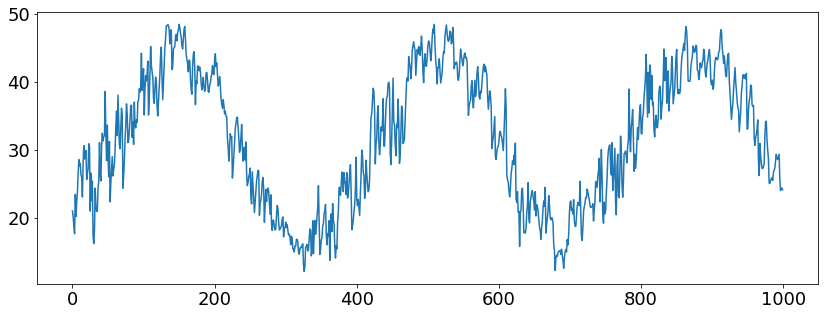

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(loc1_ts)

### Hankelization Library

In [ ]:
import numpy as np
from scipy.linalg import hankel
import math

def unfold(tensor,n):
    size = np.array(tensor.shape)
    N = size.shape[0]
    I = int(size[n])
    J = int(int(np.prod(size)) / int(I))
    pmt=np.array(range(n,n+1))
    pmt=np.append(pmt,range(0,n))
    pmt=np.append(pmt,range(n+1,N)).astype(np.int)
    return np.reshape(np.transpose(tensor, pmt),[I, J])

def fold(matrix,n,size_t_ori):
    N = np.array(size_t_ori).shape[0]
    size_t_pmt = np.concatenate([size_t_ori[n:(n+1)],size_t_ori[0:n],size_t_ori[(n+1):N]], axis=0)
    pmt = np.array(range(1,n+1))
    pmt = np.append(pmt,range(0,1))
    pmt = np.append(pmt,range(n+1,N)).astype(np.int)
    return np.transpose(np.reshape(matrix,size_t_pmt),pmt)

def make_duplication_matrix(T,tau):
    H = hankel(range(tau),range(tau-1,T))
    T2= np.prod(H.shape)
    h = np.reshape(H,[1,T2])
    h2= np.array([range(T2)])
    index = np.concatenate([h,h2],axis=0)
    S = np.zeros([T,T2], dtype='uint64')
    S[tuple(index)]=1
    return S.T

def tmult(tensor,matrix,n):
    size = np.array(tensor.shape)
    size[n] = matrix.shape[0]
    return fold(np.matmul(matrix,unfold(tensor,n)),n,size)

def hankel_tensor(x,TAU):
    N = len(TAU)
    N2= N*2
    T2  = np.zeros([N,2],dtype='uint64')
    S = list()
    Hx = x
    for n in range(N):
        tau   = TAU[n]
        T     = x.shape[n]
        T2[n,:] = [tau,T-tau+1]
        S.append(make_duplication_matrix(x.shape[n],TAU[n]))
        Hx = tmult(Hx,S[n],n)
    size_h_tensor = np.reshape(T2,[N2,])
    Hx = np.reshape(Hx,size_h_tensor)
    return Hx, S

def hankel_tensor_adjoint(Hx,S):
    N = len(S)
    size_h_tensor = np.zeros([N,], dtype='uint64')
    for n in range(N):
        size_h_tensor[n] = S[n].shape[0]
    Hx = np.reshape(Hx,size_h_tensor)
    for n in range(N):
        Hx = tmult(Hx,S[n].T,n)
    return Hx
    


In [ ]:
import numpy as np

class MDTWrapper(object):
    
    def __init__(self,data,tau=None):
        self._data = data.astype(np.float32)
        self._ori_data = data.astype(np.float32)
        self.set_tau(tau)
        is_transformed = False
        self._ori_shape = data.shape
        pass
    
    def set_tau(self, tau):
        if isinstance(tau, np.ndarray):
            self._tau = tau
        elif isinstance(tau, list):
            self._tau = np.array(tau)
        else:
            raise TypeError(" 'tau' need to be a list or numpy.ndarray")
        
    
    def get_tau(self):
        return self._tau
    
    def shape(self):
        return self._data.shape
    
    def get_data(self):
        return self._data
    
    def get_ori_data(self):
        return self._ori_data
    
    def transform(self, tau=None):       
        _tau = tau if tau is not None else self._tau
        result, S = hankel_tensor(self._data, _tau)
        self.is_transformed = True
        #print("before squeeze: ", result.shape)
        axis_dim = tuple(i for i, dim in enumerate(result.shape) if dim==1 and i!=0)
        result = np.squeeze(result,axis=axis_dim)
        #print("after squeeze: ", result.shape)
        self._data = result
        return result
    
    def inverse(self, data=None, tau=None, ori_shape=None):
        _tau = tau if tau is not None else self._tau
        _ori_shape = ori_shape if ori_shape is not None else self._ori_shape
        _data = data if data is not None else self._data
        O = np.ones(_ori_shape, dtype='uint8')
        Ho, S = hankel_tensor(O.astype(np.float32), _tau)
        D = hankel_tensor_adjoint(Ho, S)
        
        result = np.divide(hankel_tensor_adjoint(_data, S), D)
        self.is_transformed = False
        self._data = result
        return result
    
    def predict(self):
        '''
        # To do:
        # predict function
        '''
        pass

In [ ]:
def hankelize(F, L):
   N =len(F)
   K = N - L + 1 # The number of rows in the trajectory matrix.
   #Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as rows.
   Xk = np.row_stack([F[i:i+L] for i in range(0,K)])
   return Xk

In [ ]:
H=hankelize(loc1_ts, 365)

In [ ]:
H.shape

(636, 365)

In [ ]:
H[0:4,0:5]

array([[20.99857, 20.1824 , 18.71993, 17.66115, 23.43956],
       [20.1824 , 18.71993, 17.66115, 23.43956, 20.21048],
       [18.71993, 17.66115, 23.43956, 20.21048, 22.40028],
       [17.66115, 23.43956, 20.21048, 22.40028, 23.73118]])

In [ ]:
train = H[:,0:200]
test = H[:,200:]

In [ ]:
train.shape, test.shape

((636, 200), (636, 165))

In [ ]:
# construct x and y tensors and convert to TT format
number_of_snapshots=train.shape[-1] - 1

x = TT(train[:, 0:number_of_snapshots, None, None])
y = TT(train[:, 1:number_of_snapshots + 1, None, None])

In [ ]:
# modes_tdmd_full = modes_tdmd.full()[:, :, 0, 0]

# Lambda = np.diag(eigenvalues_tdmd);
# tt_lambda=TT(Lambda[None, :,None,:])
# tt_Phi = TT(modes_tdmd_full[:,:, None, None])
# tt_Phit=tt_Phi.transpose(2)
# del modes_tdmd_full
# pinv_modes = tt_Phi.pinv(tt_Phi.order - 1, threshold=threshold, ortho_l=True, ortho_r=True);
# del tt_Phi
# pinv_modes=pinv_modes.transpose()
# pinv_modest = pinv_modes.transpose(2)
# del pinv_modes
# Omega = np.log(eigenvalues_tdmd)
# tt_Phi_l = tt_Phit.dot(tt_lambda).ortho()
# Aprop = tt_Phi_l.dot(pinv_modest).ortho()

In [ ]:
eigenvalues_tdmd = [None] 

modes_tdmd = [None] 

threshold=0
eigenvalues_tdmd, modes_tdmd = tdmd_exact(x, y, threshold=0)

In [ ]:
modes_tdmd


Tensor train with order    = 2, 
                  row_dims = [636, 199], 
                  col_dims = [1, 1], 
                  ranks    = [1, 199, 1]

In [ ]:
D=np.diag(eigenvalues_tdmd)
D.shape

(199, 199)

In [ ]:
modes_tdmd.full()[:,:,0,0].shape

(636, 199)

In [ ]:
ApropU = modes_tdmd.full()[:,:,0,0]@np.linalg.pinv(modes_tdmd.full()[:,:,0,0])

In [ ]:
steps = 360
pr=train[:,0].reshape(-1,)
forecast= np.zeros((len(pr),steps));
forecast[:,0]=pr
t2=  time.time()
for step in range(steps-1):
    forecast[:,step+1]=(np.real(ApropU@forecast[:,step])).reshape(-1,)
print("--- %s seconds ---" % (time.time() - t2))   

--- 0.577639102935791 seconds ---


In [ ]:
forecast.shape

(636, 360)

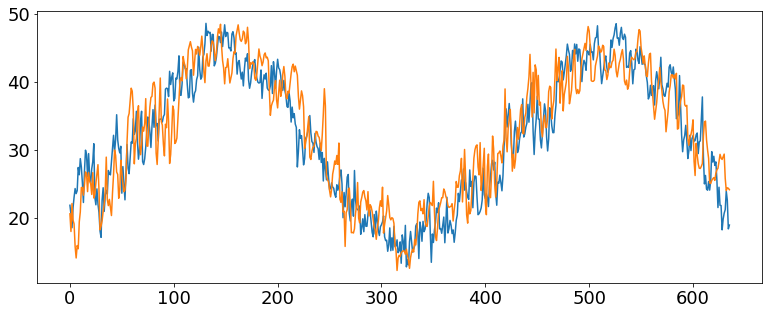

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(forecast[:,-1])
plt.plot(test[:,-1])